# Simple regression: a quick review.

Some $\LaTeX$ needs to go here for Quarto’s own crazy reasons.

# Goals

-   Introduce some other ways to fit lines through data
    -   Grouping data
    -   Swapping regressors and responses
    -   Minimizing absolute error
    -   Taking averages within buckets
-   Set up the question of the strengths and weaknesses of least squares
    methods

# Scenario

Suppose we’re a Spotify engineer and we pulled this data from one
datacenter at one particular time, and we’re exploring / sanity checking
the ML outputs.

We’ll assume that song popularity is relatively objective (e.g. number
of listens), but the various song features (particularly danceability)
are the output of ML systems that we want to sanity check.

We hope that our ML features are at least somewhat related to
popularity. (*Why?*) Our whole problem is that this graph is not easy to
interpret:

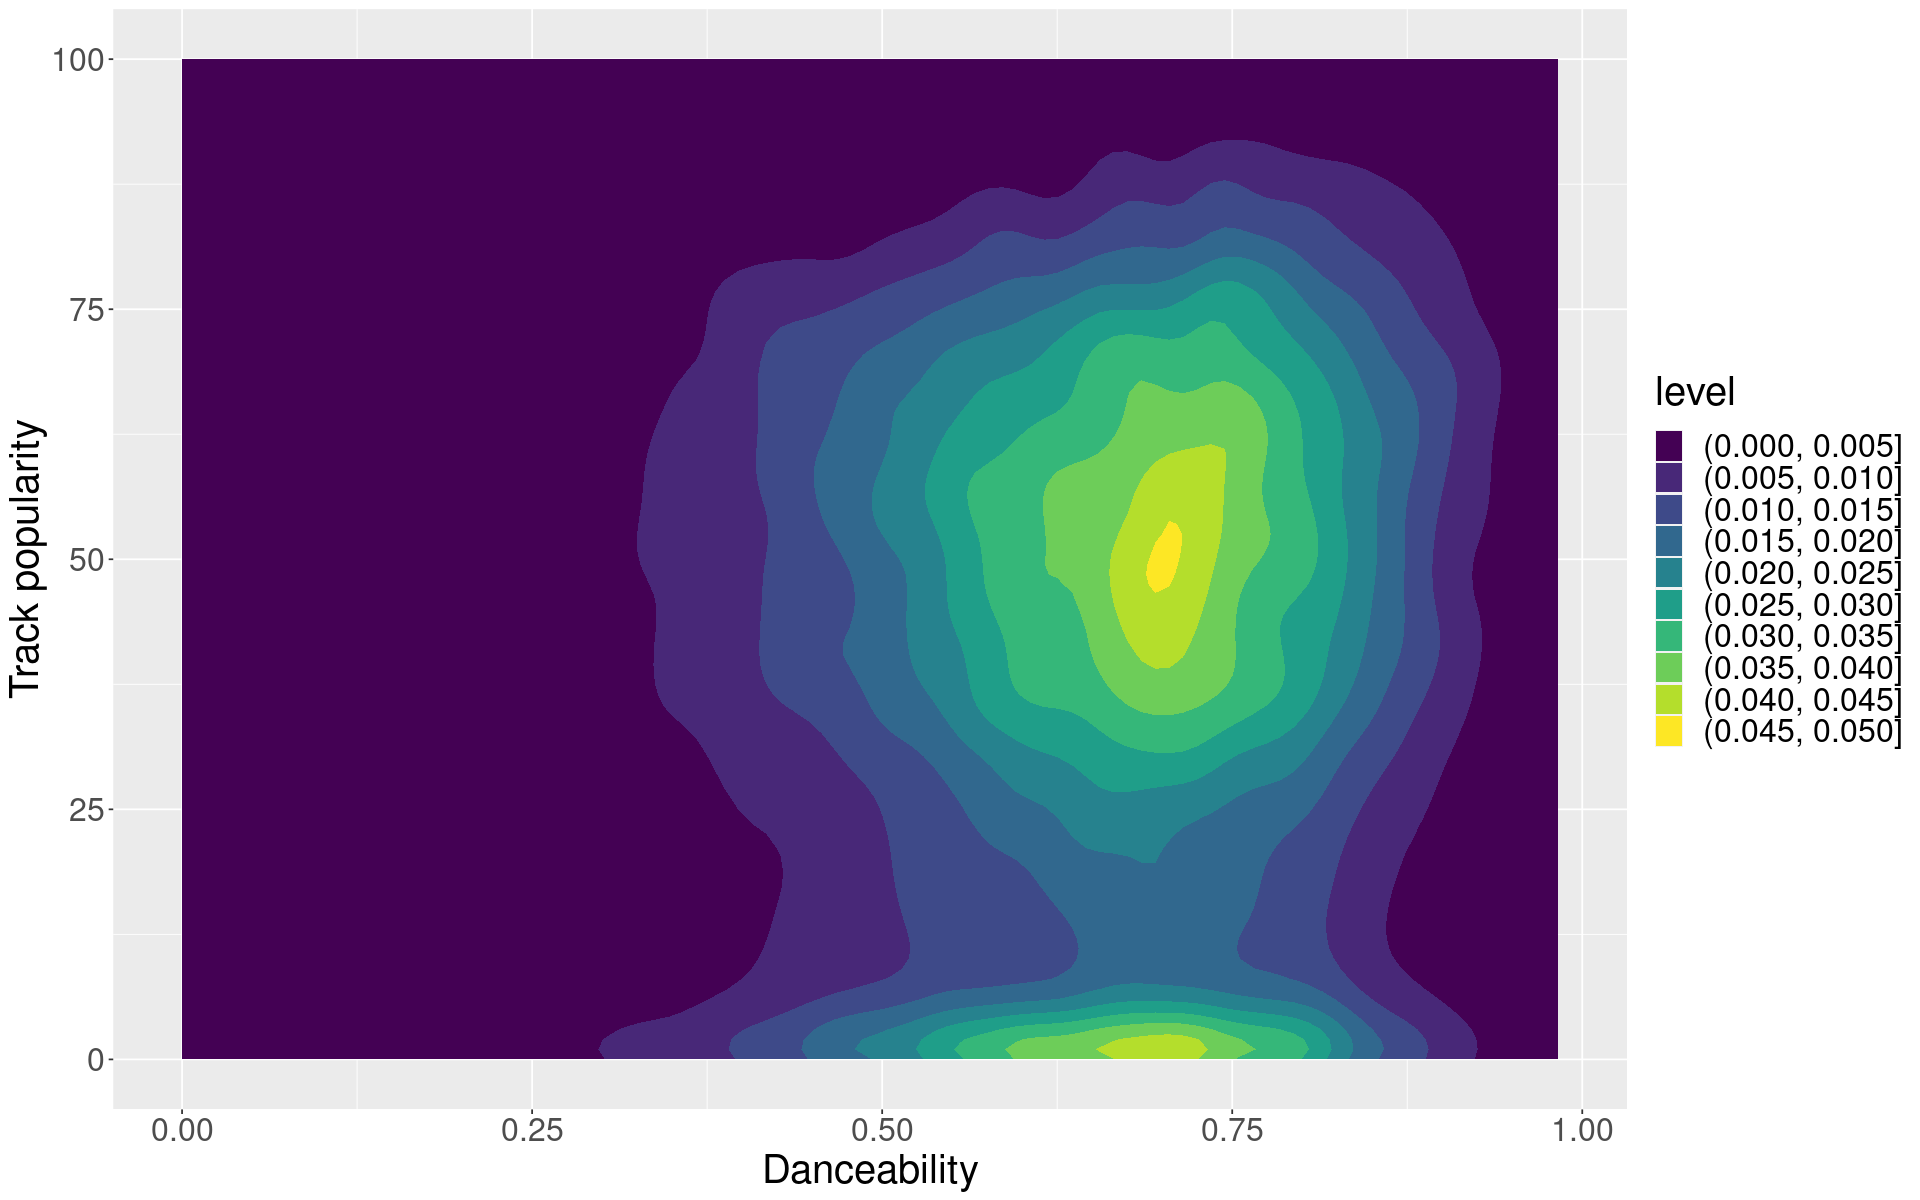

In [11]:
PlotBaseSpotify <- function() {
    ggplot(spotify_df, aes(y=track_popularity, x=danceability)) + 
      geom_density_2d_filled() +
      ylab("Track popularity") + xlab("Danceability") +
      theme()
}

PlotBaseSpotify()

Basically we want some kind of low-dimensional summary of a potentially
complex relationship in the data.

# Grouping data to get an exactly identified system of equations

One perspective on the problem of line-fitting is that we have two
degrees of freedom (the slope and the intercept), but more than two
equations to satisfy.

If the data looked like this:

$$
\begin{align*}
\y_1 ={}& \beta_0 + \beta_1 \x_1 \\
\y_2 ={}& \beta_0 + \beta_1 \x_2 \\
\end{align*}
$$ then we would be able to identify $\beta_1$ and $\beta_2$
unambiguously:

$$
\begin{align*}
\beta_1 ={}& \frac{\y_1 - \y_2}{\x_2 - \x_1}\\
\frac{\y_1}{\x_1} - \frac{\y_2}{\x_2} ={}& \left(\frac{1}{\x_1} -  \frac{1}{\x_2}\right)\beta_1 \Rightarrow\\
\beta_0 ={}& \frac{\x_1 \y_2 - \x_2 \y_1}{\x_1 - \x_2}
\end{align*}
$$

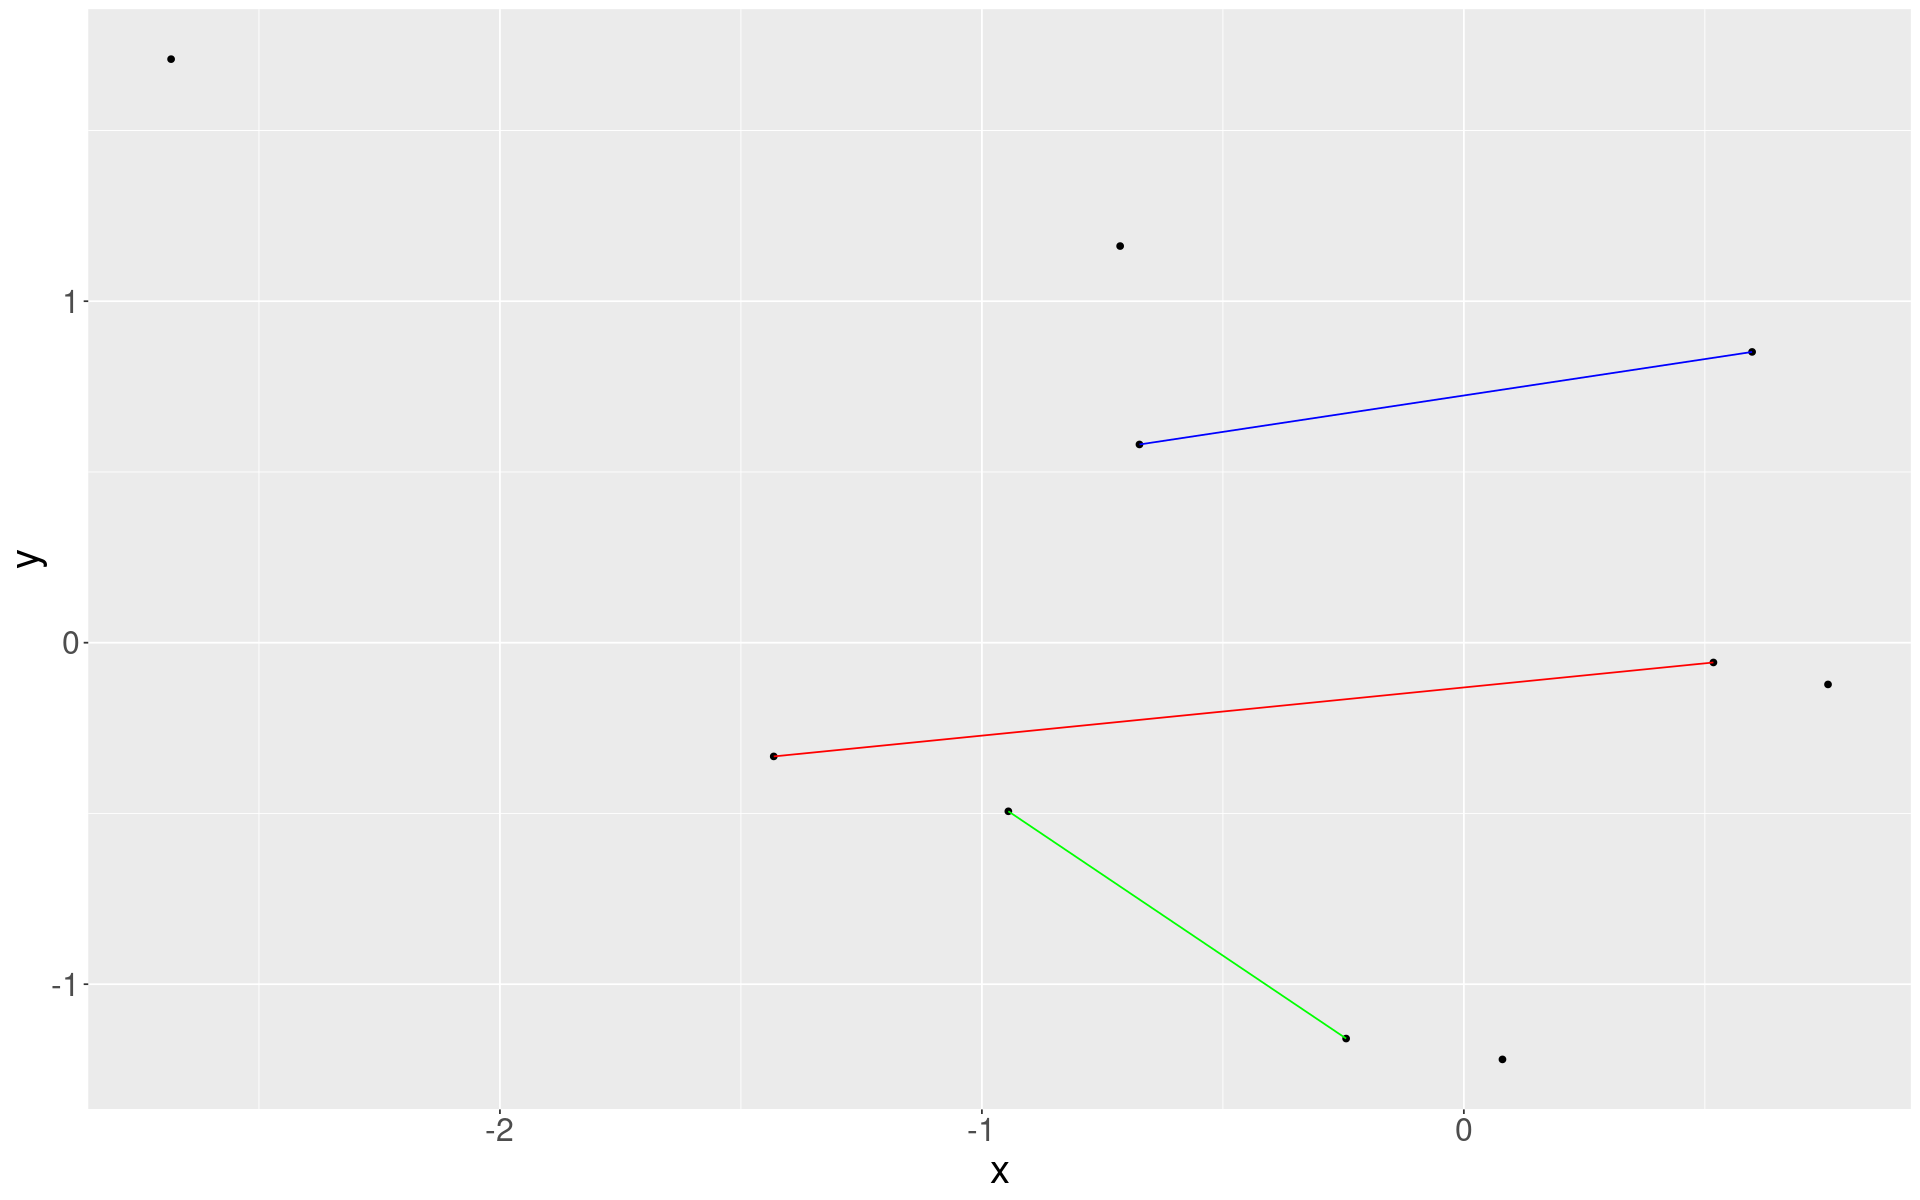

In [3]:
simple_df <- data.frame(x=rnorm(10)) %>% mutate(y=0.2 * x + rnorm(10))

ggplot(simple_df) +
  geom_point(aes(x=x, y=y)) +
  geom_line(aes(x=x, y=y), data=simple_df[c(1, 2), ], color="red") +
  geom_line(aes(x=x, y=y), data=simple_df[c(3, 4), ], color="blue") +
  geom_line(aes(x=x, y=y), data=simple_df[c(5, 6), ], color="green")


The problem is that we have more equations to satisfy than we have
degrees of freedom:

$$
\begin{align*}
\y_1 ={}& \beta_1 + \beta_2 \x_1 \\
\y_2 ={}& \beta_1 + \beta_2 \x_2 \\
\y_3 ={}& \beta_1 + \beta_2 \x_3 \\
\vdots\\
\y_N ={}& \beta_1 + \beta_2 \x_N.
\end{align*}
$$ In general, no choice of $\beta_1$ and $\beta_2$ will satisfy them.

Here’s the method used by early mathematicians prior to the invention of
least squares regression (Stigler 1990): sum equations together until we
get an exactly determined system. In this case, we can partition the
data into two groups, A and B, add them up, to get two equations again.
Let $N_A$ and $N_B$ be the number of observations in the two groups.
Then

$$
\begin{align*}
\frac{1}{N_A} \sum_{A} \y_n ={}& \beta_1 + \frac{1}{N_A} \sum_{A} \x_n \beta_2 \\
\frac{1}{N_B} \sum_{B} \y_n ={}& \beta_1 + \frac{1}{N_B} \sum_{B} \x_n \beta_2 .
\end{align*}
$$

This gives us the slope

$$
\beta_2 = \frac{\frac{1}{N_A} \sum_{A} \y_n - \frac{1}{N_B} \sum_{B} \y_n}
               {\frac{1}{N_A} \sum_{A} \x_n - \frac{1}{N_B} \sum_{B} \x_n}.
$$

Is this reasonable? What grouping is best? What groupings fail? Should
you weight the groups, and if so, how? A clear answer will be something
we learn in this course.

In the meantime, let’s take a look.

In [4]:
# Return the slope and intercept of a line passing through two points.
# Args:
#  - x: Two points in the domain
#  - y: Two points in the range
# Returns:
#  - beta: A vector containing the intercept and slope
FitTwoPointLine <- function(x, y) {
  stopifnot(length(x) == 2)
  stopifnot(length(y) == 2)
  slope <- (y[2] - y[1])  / (x[2] - x[1])
  intercept <- (y[2] * x[1] - y[1] * x[2])  / (x[1] - x[2])
  return(c(intercept, slope))
}

In [5]:
# Fit a line using the above grouping formula.
#
# Args:
#   - group: A vector as long as spotify_df containing two values
#
# Returns:
#  - beta: The estimated intercept and slope
#  - y_vals: The mean of the y values in the two groups
#  - x_vals: The mean of the x values in the two groups
#  - df: The grouped dataframe
GetGroupedTerms <- function(group) {
  stopifnot(length(group) == nrow(spotify_df))
  stopifnot(length(unique(group)) == 2)  # Check there are exactly two values
  
  spotify_group_df <-
    spotify_df %>%
    mutate(group=group) %>%
    group_by(group) %>%
    summarize(popularity_mean=mean(track_popularity),
              danceability_mean=mean(danceability),
              count=n()) 

  stopifnot(nrow(spotify_group_df) == 2)
  
  ycol <- "popularity_mean"
  xcol <- "danceability_mean"
  y_vals <- c(spotify_group_df[1, ][[ycol]], spotify_group_df[2, ][[ycol]])
  x_vals <- c(spotify_group_df[1, ][[xcol]], spotify_group_df[2, ][[xcol]])

  beta <- FitTwoPointLine(x_vals, y_vals)
  #beta1 <- (y_vals[1] * x_vals[2] - y_vals[2] * x_vals[1]) / (x_vals[2] - x_vals[1]) 
  #beta2 <- (y_vals[2] - y_vals[1]) / (x_vals[2] - x_vals[1])
  
  return(list(beta=beta, y=y_vals, x=x_vals, df=spotify_group_df))
}


Suppose, for example, that we take the groups to be the data with
dancability below or above its median. The results are pretty good:

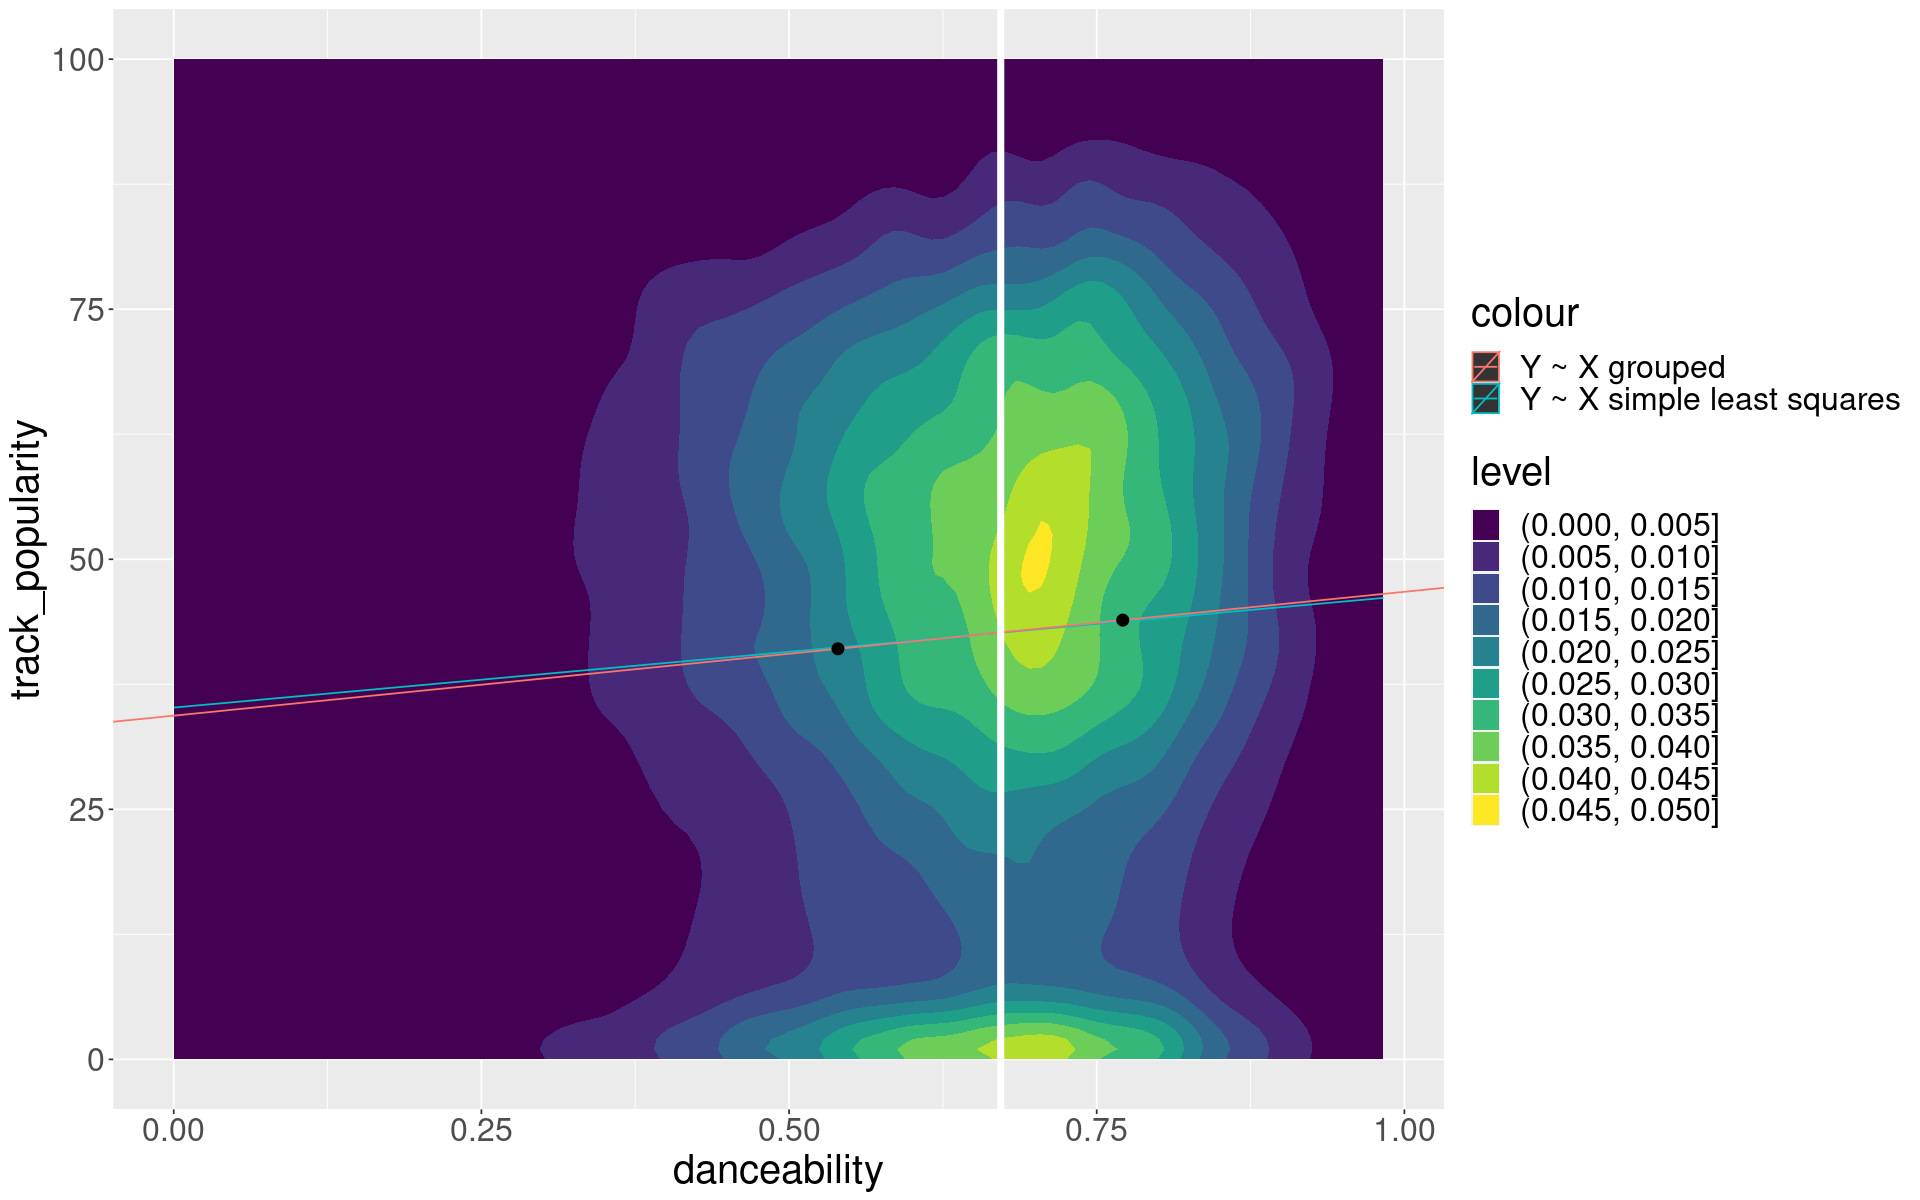

In [6]:
x_median <- median(spotify_df$danceability)
group <- ifelse(spotify_df$danceability <= x_median, "A", "B")
grouped_fit <- GetGroupedTerms(group)

# Compute the ordinary least squares estimate for comparison
y_on_x <- lm(track_popularity ~ danceability, spotify_df)
  
PlotBaseSpotify() +
  geom_line(aes(y=y_on_x$fitted.values, 
              color="Y ~ X simple least squares")) +
  geom_abline(aes(slope=grouped_fit$beta[2], intercept=grouped_fit$beta[1],
              color="Y ~ X grouped")) +
  geom_vline(aes(xintercept=x_median), color="white", lwd=2) +
  geom_point(aes(x=x, y=y), size=3, data=data.frame(x=grouped_fit$x, y=grouped_fit$y))

What if we do the same thing, but randomly assign the groups. The result
is garbage!

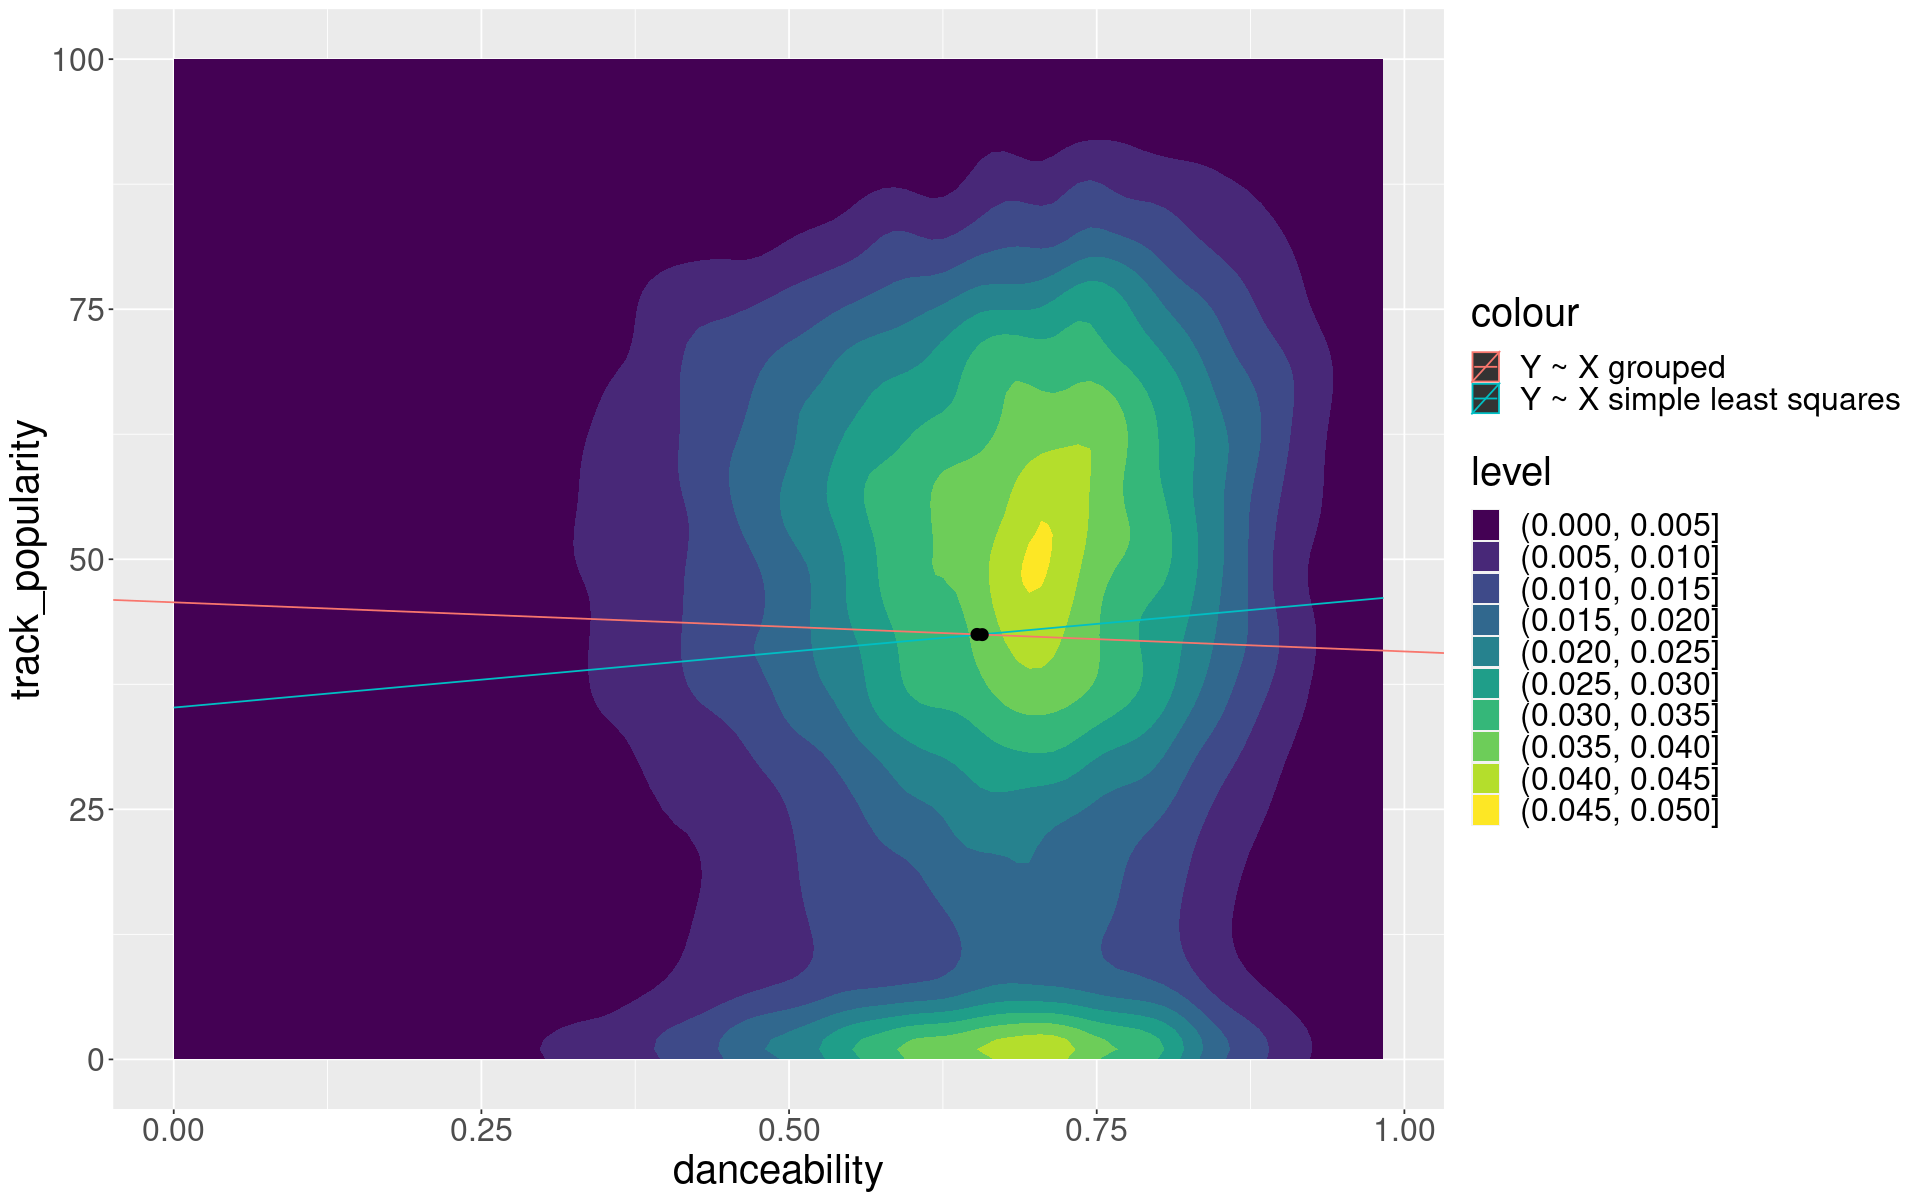

In [7]:
rand_group <- sample(c("A", "B"), nrow(spotify_df), replace=TRUE)
rand_grouped_fit <- GetGroupedTerms(rand_group)
  
PlotBaseSpotify() +
  geom_line(aes(y=y_on_x$fitted.values, 
              color="Y ~ X simple least squares")) +
  geom_abline(aes(slope=rand_grouped_fit$beta[2], intercept=rand_grouped_fit$beta[1],
              color="Y ~ X grouped")) +
  geom_point(aes(x=x, y=y), size=3, data=data.frame(x=rand_grouped_fit$x, y=rand_grouped_fit$y))

Perhaps at this point it is not clear what went wrong in the second
case, nor how you might choose good groupings with more than one
regressor. But by the end of this class we will understand very well.

# Other errors to minimize

Here’s a slightly more sophisticated way to think about the problem.

1.  Recognize that, in an overdetermined system, some “equations” will
    not be satisfied exactly
2.  Write out the errors explicitly and choose a line based on some
    criterion that makes the errors “small”

Specifically, we want a line passing through popularity and
danceability. Such a line will look like

$$
\begin{align*}
\y_n :={}& \textrm{Popularity} \\
\x_n :={}& \textrm{Danceability}\\
y_n ={}& \beta_1 \x_n + \beta_0 + \res_n\\
\end{align*}
$$

Here, the error we commit in equation $n$ is given by $\reshat_n$. Of
course, we might well have written

$$
\begin{align*}
x_n ={}& \alpha_1 \y_n + \alpha_0 + \gamma_n.
\end{align*}
$$

For a particular $\beta$, we get a vector of $\res_1, \ldots, \res_N$.
We want these all to be “small” in some sense. Two natural ways to do so
are to minimize the sum or squares or sum of absolute values:

$$
\begin{align*}
\textrm{Choosing the fit using }&
\min \sumn \reshat_n^2 \quad\textrm{(least squares)}\\
\textrm{or }&
\min \sumn |\reshat_n| \quad\textrm{(least absolute deviations)}\\
\end{align*}
$$ We thus have four combinations to try: $\y_n$ or $\x_n$ on the left
hand side, and minimizing the sum of squares or sum of absolute
deviations.

We can compute all these in `R` and see how they look on the Spotify
data. Before we do, try to predict yourself.

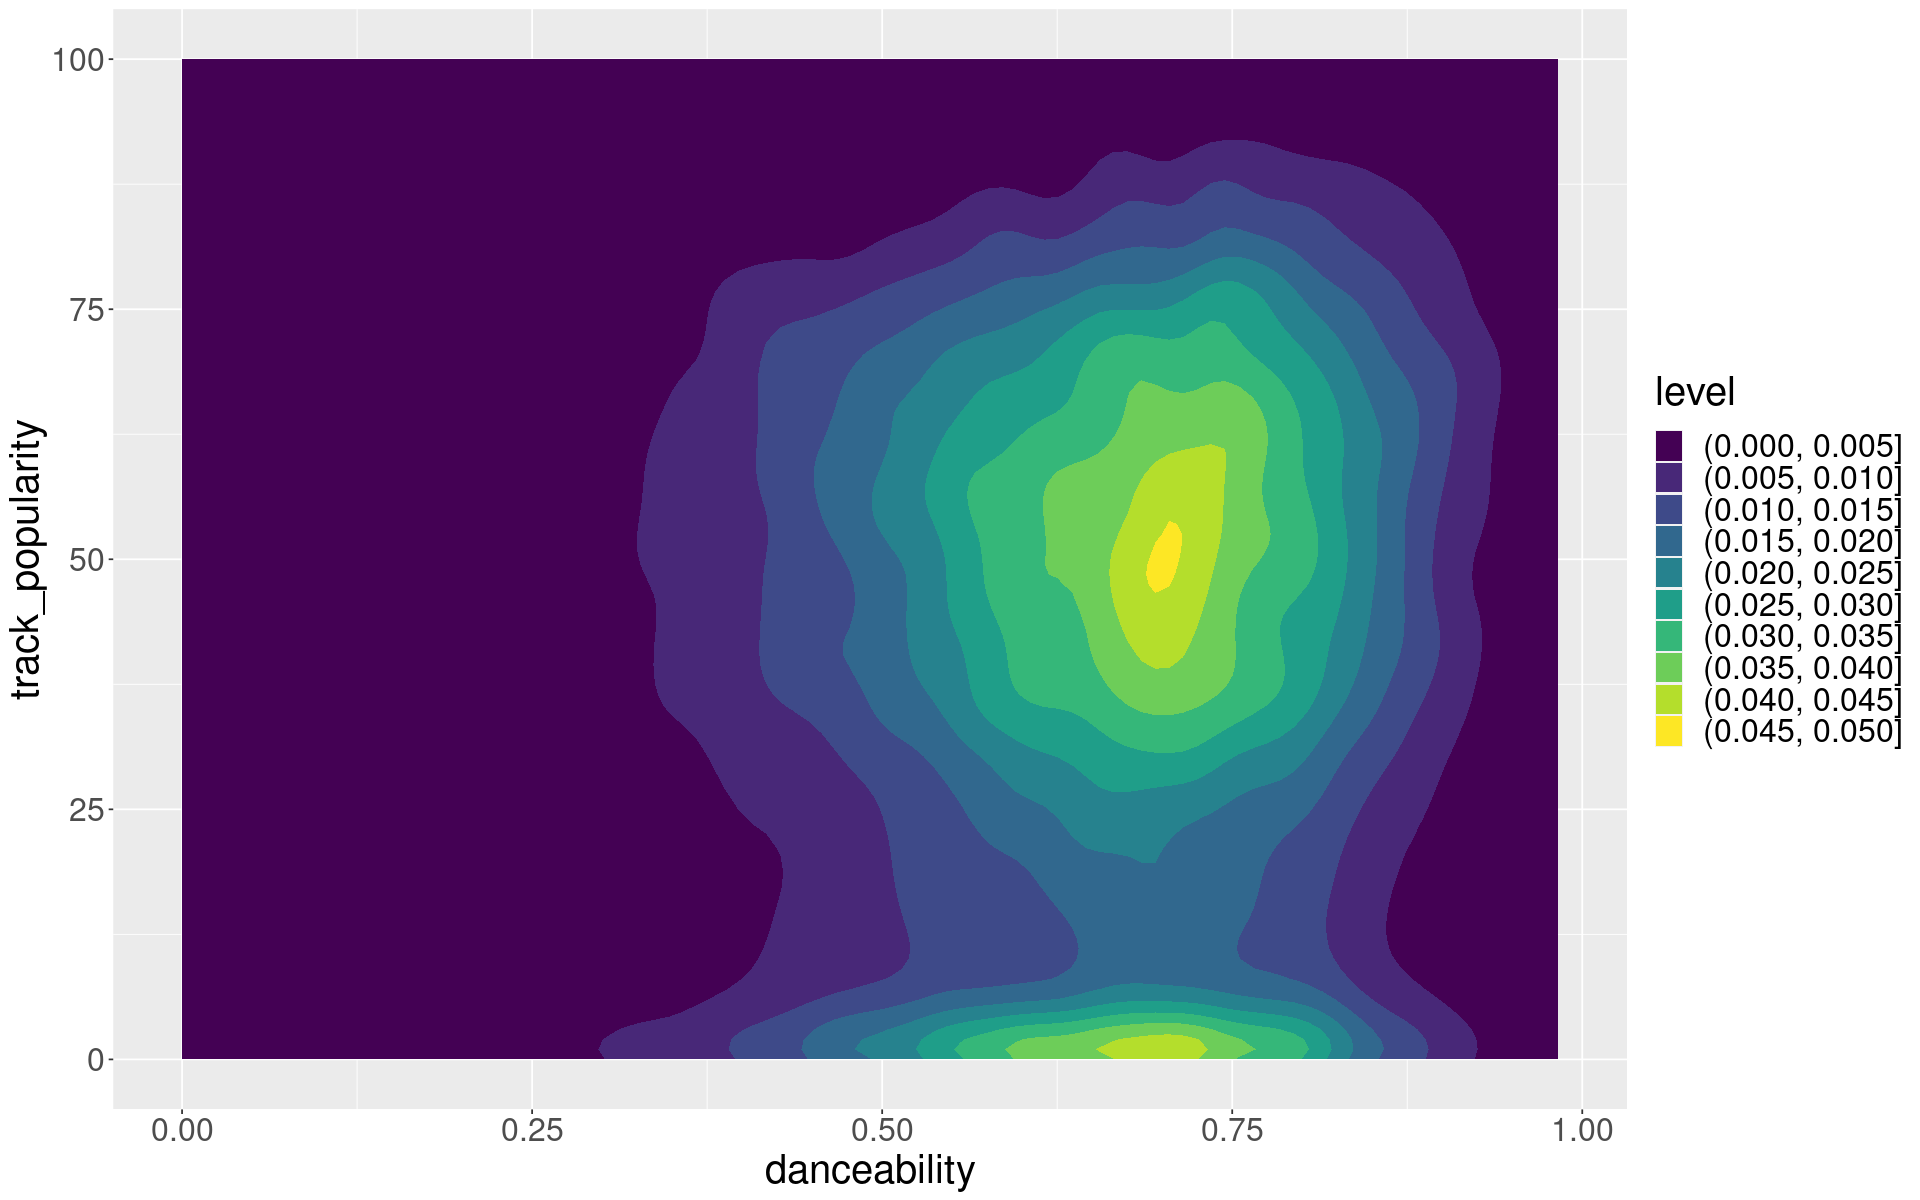

In [8]:
PlotBaseSpotify()

In [9]:
least_squares_time <- Sys.time()
y_on_x <- lm(track_popularity ~ danceability, spotify_df)
least_squares_time <- Sys.time() - least_squares_time

least_abs_time <- Sys.time()
y_on_x_l1 <- l1fit(x=spotify_df$danceability, y=spotify_df$track_popularity, intercept=TRUE)
least_abs_time <- Sys.time() - least_abs_time

x_on_y <- lm(danceability ~ track_popularity, spotify_df)
x_on_y_l1 <- l1fit(x=spotify_df$track_popularity, y=spotify_df$danceability, intercept=TRUE)

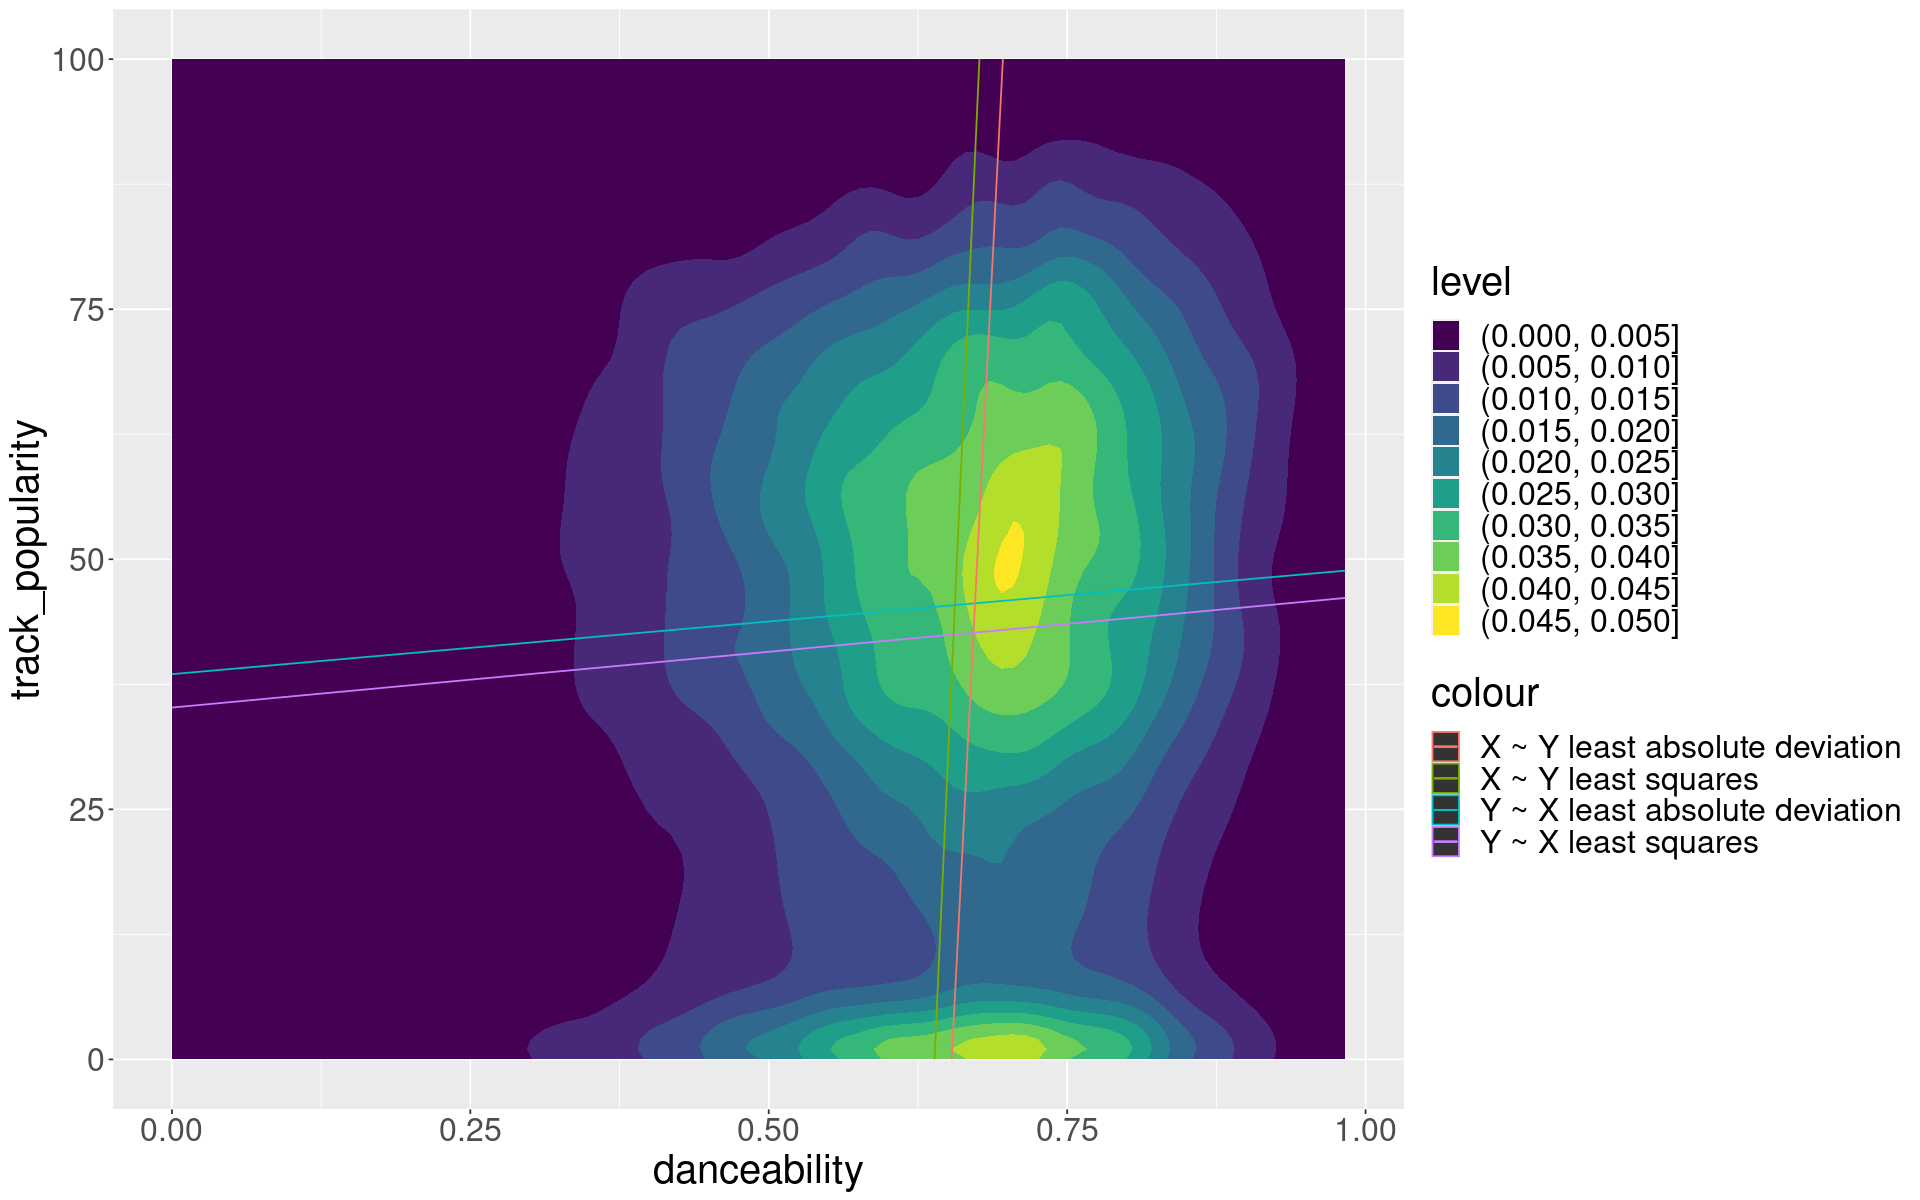

In [10]:
PlotBaseSpotify() +
  geom_line(aes(y=y_on_x$fitted.values, color="Y ~ X least squares")) +
  geom_line(aes(x=x_on_y$fitted.values, color="X ~ Y least squares")) +
  geom_line(aes(y=y_on_x_l1$fitted.values, color="Y ~ X least absolute deviation")) +
  geom_line(aes(x=x_on_y_l1$fitted.values, color="X ~ Y least absolute deviation"))

Note that it matters a lot whether you have $\y$ or $\x$ on the
left-hand side. (To gain some intuition for this, think about what
happens as you transform data that lies on a straight line into data in
an uncorrelated point cloud.)

Let’s see the relative times:

In [ ]:
cat("Least absolute deviation time:\t", least_abs_time, "\n")
cat("Least squares time:\t\t", least_squares_time, "\n")

Least squares took much longer! Why? We’ll talk about that shortly.

## Nonparameteric lines

For only one variable, regression is actually no a very good solution.
We would actually probably use something more “nonparametric.” For
example, we could bucket up the regressors and keep an average in each
bucket.

In [ ]:
num_buckets <- 20
spotify_bucketed_df <- spotify_df %>%
  mutate(danceability_bucket=cut(danceability, num_buckets)) %>%
  group_by(danceability_bucket) %>%
  summarise(mean_popularity=mean(track_popularity),
            bucket_danceability=median(danceability),
            count=n())

PlotBaseSpotify() +
  geom_line(aes(y=y_on_x$fitted.values, color="Y ~ X least squares")) +
  geom_line(aes(x=bucket_danceability, 
                y=mean_popularity,
                color="Averages in buckets"),
            data=spotify_bucketed_df)

What do you think of this line’s behavior for low danceability?

Note that `cut` takes evenly spaced slices, which leads to a very uneven
distribution of observations in each bucket. How do you think this
affects the graph we saw before?

In [ ]:
ggplot(spotify_bucketed_df) +
  geom_line(aes(x=bucket_danceability, y=count))

There are more sophisitcated ways to do “nonparametric” smoothers like
this automatically, including built-in functions in `R`.

In [ ]:
PlotBaseSpotify() +
  geom_line(aes(y=y_on_x$fitted.values, color="Y ~ X least squares")) +
  geom_smooth(aes(color="Ggplot smooth"))

The core problem with nonparametrics is the curse of dimensionality.
Suppose we have $P$ regressors, and we divide each into ten buckets. In
total, we have $10^P$ buckets, and, on average, $N / 10^P$ observations
per bucket. Here are some values for the Spotify dataset:

In [ ]:
regressors <- c("danceability", "energy", "loudness", "speechiness", 
                 "acousticness", "instrumentalness", "liveness")
stopifnot(all(regressors %in% names(spotify_df)))

for (p in 1:length(regressors)) {
  num_buckets = 10^p
  cat(sprintf("With %d buckets, we have %0.3f observations per bucket.",
              p, nrow(spotify_df) / num_buckets), "\n")
}

So the strength of regression for EDA is really in higher-dimensional
settings. For example, if we wanted to look at all the outputs at once:

In [ ]:
lm_formula <-
  paste0("track_popularity ~ 1 + ",
         paste(regressors, collapse=" + "))
print(lm_formula)

spotify_reg_all <- lm(formula(lm_formula), spotify_df)

print(summary(y_on_x))
print(summary(spotify_reg_all))

Note that the high dimensional fit can look a bit chaotic when projected
onto one dimension:

In [ ]:
PlotBaseSpotify() +
  geom_line(aes(y=spotify_reg_all$fitted.values, 
                color="Y ~ X high dimensional least squares ")) +
    geom_line(aes(y=y_on_x$fitted.values, 
                color="Y ~ X simple least squares"))

# Comparison with least squares

We saw a few other ways to fit lines. It turns out that all of these
actually have close relationships to least squares regression.

-   Grouping data
    -   Grouping data can be seen as a special case of weighting data
    -   Least squares regression can be seen a an “optimal grouping” in
        some senses (which may not matter in practice)
-   Flipping the order of the regressor and response
    -   Related to “regression to the mean”
    -   Related to “errors in variables” problems
-   Minimizing absolute error
    -   Computationally more expensive
    -   Can be a more reasonable loss function (less susceptible to
        outliers)
-   Bucketing regressors and taking averages (and other nonparametric
    methods)
    -   Many versions can be cast as regression with carefully chosen
        regressors
    -   Often more reasonable in low dimensions
    -   Difficult in high dimensions
    -   Have to choose how “expressive” the model is

In fact, by studying linear regression, we will be casting light on all
of these apparent alternatives.

Stigler, S. 1990. *The History of Statistics*. Harvard University Press.